In [1]:
import os
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. tfrecord load

In [2]:
tfr_train_dir = '/content/drive/Shared drives/GOFOODA/data/food_data.tfr'

raw_image_dataset = tf.data.TFRecordDataset(tfr_train_dir)

# Create a dictionary describing the features.
image_feature_description = {
    'image' : tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.int64}>

기존에 tfrecord에 담겨있는 이미지는 bytes형태로 저장되어 있기 때문에 이를 tensor로 읽어들이기 위해선 ```tf.image.decode_jpeg```를 활용한다

tf.Tensor(18, shape=(), dtype=int64)


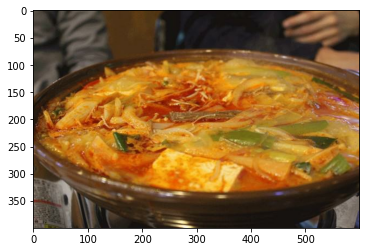

tf.Tensor(18, shape=(), dtype=int64)


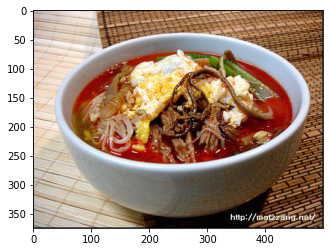

tf.Tensor(18, shape=(), dtype=int64)


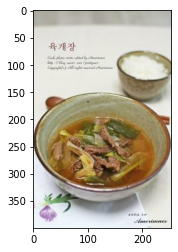

tf.Tensor(18, shape=(), dtype=int64)


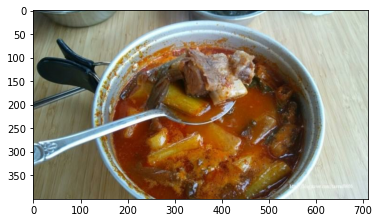

tf.Tensor(18, shape=(), dtype=int64)


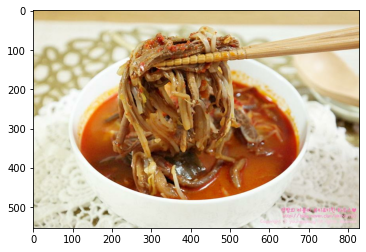

In [3]:
for image_features in parsed_image_dataset.take(5):
    print(image_features['label'])
    image_raw = image_features['image'].numpy()
    plt.imshow(tf.image.decode_jpeg(image_raw))
    plt.show()

[dataset을 split하는 방법](https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test)
- 기존에 데이터가 섞여있지 않은 채로 Dataset으로 만들어져 있기 때문에 위와 같은 방법으로 train(8), valid(1), test(1)로 나눈다.

In [4]:
DATASET_SIZE = 23484
BATCH_SIZE = 128
IMAGE_SIZE = 224

In [5]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

In [6]:
dataset = parsed_image_dataset.shuffle(DATASET_SIZE)
# train
train_ds = dataset.take(train_size)
# valid
valid_ds = dataset.skip(train_size)
valid_ds = dataset.take(val_size)
# test
test_ds = valid_ds.skip(val_size)
test_ds = valid_ds.take(test_size)

In [7]:
def decode_img(data):
    image = data['image']
    label = data['label']

    image = tf.image.decode_image(image, channels=3, expand_animations = False)
    # image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (224, 224))
    
    label = tf.one_hot(label, 25)

    return image, label

In [8]:
train_ds = train_ds.map(decode_img)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
valid_ds = valid_ds.map(decode_img)
valid_ds = valid_ds.batch(BATCH_SIZE)

# 모델 생성
---
기존의 EfficientNetB0모델을 가져온다.

In [10]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
    )

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [12]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(25, activation='softmax')

model = tf.keras.Sequential([
                             base_model,
                             flatten_layer,
                             dense_layer,
                             prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 25)                12825     
Total params: 36,175,548
Trainable params: 36,133,525
Non-trainable params: 42,023
_________________________________________________________________


In [13]:
mc_dir_path = '/content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/'
mc_path = os.path.join(mc_dir_path, 'EfficientNet_trail-001.h5')

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=mc_dir_path+'{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    )

In [15]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data = valid_ds,
    steps_per_epoch=DATASET_SIZE//BATCH_SIZE,
    callbacks=[es, mc]
)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.7733
Epoch 00001: val_accuracy improved from -inf to 0.87394, saving model to /content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/1-0.41-0.87.h5
183/183 [==============================] - 114s 624ms/step - loss: 0.8433 - accuracy: 0.7733 - val_loss: 0.4131 - val_accuracy: 0.8739
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9171
Epoch 00002: val_accuracy improved from 0.87394 to 0.92973, saving model to /content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/2-0.25-0.93.h5
183/183 [==============================] - 111s 605ms/step - loss: 0.2789 - accuracy: 0.9171 - val_loss: 0.2514 - val_accuracy: 0.9297
Epoch 3/100
183/183 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9362
Epoch 00003: val_accuracy improved from 0.92973 to 0.94336, saving model to /content/drive/Shared drives/GOFOODA/data/Efficent

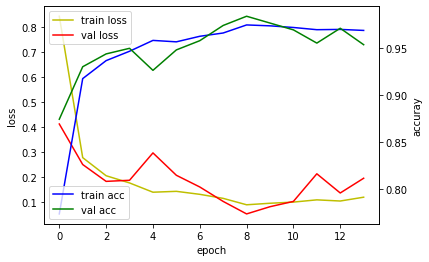

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.savefig('/content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/result.png')
plt.show()